In [1]:
#Import packages
import numpy as np
import pandas as pd
from basic_utils import *
import plotly.express as px
from statistics import mean
from scipy.stats import pearsonr

#Load data
data_original = np.load("/Users/christianbutcher/Documents/Local Docs/Thesis/Data/M2_matrix.npy")
mz_vector = np.load("/Users/christianbutcher/Documents/Local Docs/Thesis/Data/M2_mz_vector.npy")
row2grid = np.load("/Users/christianbutcher/Documents/Local Docs/Thesis/Data/M2_row2grid.npy")

data = np.copy(data_original)
data[data <= 0] = 0
residual = np.copy(data_original)
residual[residual > 0] = 0

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [96]:
###Run this code to get distribution of distance values

#Now record mean matrix distance from new mz value in order to determine distribution of values (same as below but saving all distances)
indices_iter2 = iter(range(len(mz_vector)-5))
mean_matr_dist2 = []
for i in indices_iter2:
    indices2 = range(i,i+6)

    matrix_distances2 = []

    new_pixel2 = make_image(row2grid, data[:,indices2[5]])

    for j in indices2[0:5]:

        #Look at 'distance' between pixel matrices
        pixel2 = make_image(row2grid, data[:,j])

        matrix_distance2 = np.linalg.norm(new_pixel2-pixel2)
        matrix_distances2 += [matrix_distance2]


    mean_matr_dist2 += [mean(matrix_distances2)]

#Plot distribution of all matrix distances
px.histogram(mean_matr_dist2, labels={'value':'Difference Value'}, template='seaborn')


In [ ]:
#For non-normalised matrices

#97.2 less than 250
#96.6% of the distances are smaller than 200
#95.8% less than 150
#91.1% less than 100

#96.3% less than 175
sum(i < 150 for i in mean_matr_dist2)/len(mean_matr_dist2)

In [4]:
###Run this code to obtain change values

#Slide through range of m/z values and obtain change values
from statistics import mean

indices_iter = iter(range(len(mz_vector)-5))
change_values = []

for i in indices_iter:
    indices = range(i,i+6)


    ##max_intensities = []
    ##new_max_intensity = max(data[:,indices[5]])

    matrix_distances = []

    new_pixel = make_image(row2grid, data[:,indices[5]])

    for j in indices[0:5]:
        #Look for change in max intensity
        ##max_intensities += [max(data[:,j])]

        #Look at 'distance' between normalised pixel matrices
        pixel = make_image(row2grid, data[:,j])


        matrix_distance = np.linalg.norm(new_pixel-pixel)
        matrix_distances += [matrix_distance]


    mean_matr_dist = mean(matrix_distances)
    ##max_intensity_ttest = ttest_ind(max_intensities, new_max_intensity)


    if mean_matr_dist > 150:
        change_values += [mz_vector[indices[5]]]
        next(indices_iter)
        next(indices_iter)
        next(indices_iter)
        next(indices_iter)

        
        

In [6]:
#Creating the groups of mz values based on previously obtained change values

groups = []
temp_list = []

for i in range(len(mz_vector)):
    if len(np.intersect1d(mz_vector[i], change_values)) == 0:
        temp_list.append(mz_vector[i])
        
    else:
        groups.append(temp_list)
        temp_list = []
        temp_list.append(mz_vector[i])

groups.append(temp_list)

In [10]:
#For each group, calculate the mean ion image (and include min/max m/z value for each group)

representative_matr = []
for j in range(len(groups)):
    temp_matr = np.zeros((228,165))
    for i in range(len(groups[j])):
        ind = find_nearest_idx(mz_vector, groups[j][i])
        new_matr = make_image(row2grid, data[:,ind])
        temp_matr += new_matr

    temp_matr = temp_matr / len(groups[j])
    representative_matr += [[temp_matr, groups[j][0], groups[j][-1]]]

In [14]:
#Calculating pearson correlation between insulin group (31) and every other group
pearson_tests = []
for i in range(len(representative_matr)):
    insulin_flat = np.ndarray.flatten(representative_matr[31][0])
    pearsons_temp = []
    i_flat = np.ndarray.flatten(representative_matr[i][0])

    temp_test, temp_pval = pearsonr(insulin_flat, i_flat, alternative='greater')


    pearson_tests.append([31, i, 'Group ' + str(31), 'Group ' + str(i), temp_test, np.round(temp_pval,8)])


#Plot histogram of the Pearson coefficients
px.histogram([item[-2] for item in pearson_tests], nbins=10, labels={'value':'Pearson Coefficient',
                                                                     'count':'Count'}, template='seaborn')

In [16]:
#Filter correlations larger than cutoff
strong_corr = [item for item in pearson_tests if abs(item[-2])>0.5]
strong_corr

#For each group that is correlated with insulin group, get representative m/z value by finding max Frob. norm
group_rep_mz = []
for i in range(len(strong_corr)):
    norms = []
    group_no = strong_corr[i][1]
    for j in range(len(groups[group_no])):
        ind = find_nearest_idx(mz_vector, groups[group_no][j])
        ion_im = make_image(row2grid, data[:,ind])
        fro_norm = np.linalg.norm(ion_im)
        norms += [fro_norm]
    max_norm = max(norms)
    max_index = norms.index(max_norm)

    group_rep_mz += [["Group " + str(group_no), groups[group_no][max_index]]]

In [ ]:
#Save the values
#### Make sure to rename file each time ####

# with open(r'/Users/christianbutcher/Documents/Local Docs/Thesis/Output Values/candidate_vals_150_mean', 'w') as fp:
#     for item in group_rep_mz:
#         # write each item on a new line
#         fp.write("%s\n" % item)
#     print('Done')

In [20]:
#Collect candidate artefact values into one object
candidate_vals = []
for i in range(len(group_rep_mz)):
    candidate_vals += [group_rep_mz[i][1]]

candidate_vals = np.asarray(candidate_vals)
candidate_vals

(0.95, 1.05)

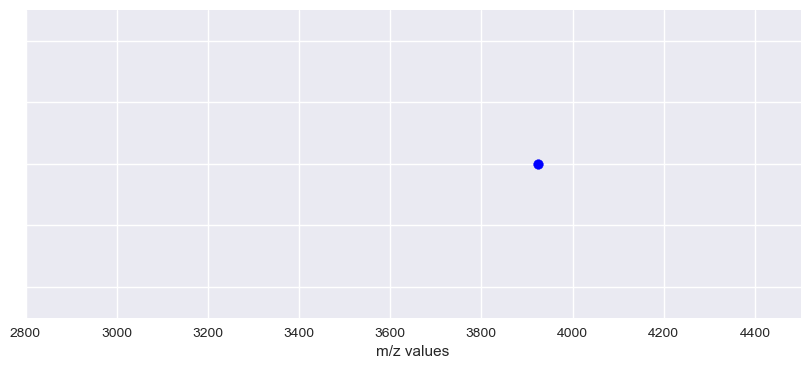

In [22]:
#Plot chandidate values
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(10,4))
plt.scatter(candidate_vals, y=np.repeat(1,len(candidate_vals)), c='blue')
plt.xlabel('m/z values')
plt.tick_params(left = False, labelleft=False)
plt.xlim(2800,4500)
plt.ylim(0.95,1.05)

(5600.0, 6100.0)

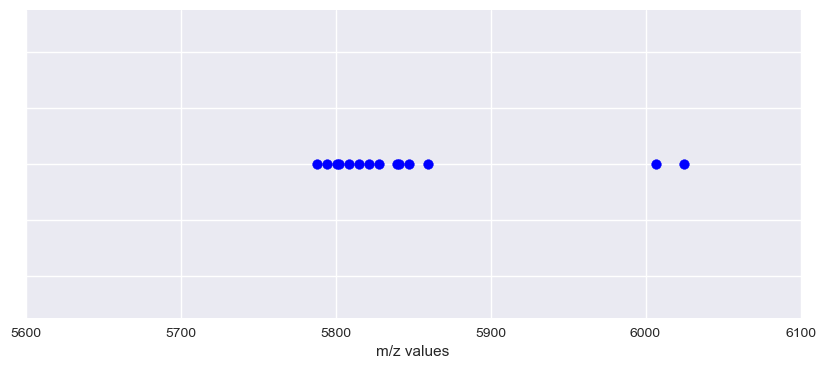

In [23]:
#Plot chandidate values
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(10,4))
plt.scatter(candidate_vals, y=np.repeat(1,len(candidate_vals)), c='blue')
plt.xlabel('m/z values')
plt.tick_params(left = False, labelleft=False)
plt.xlim(5600,6100)

(0.9, 1.1)

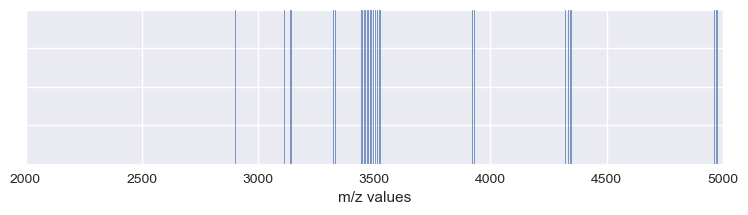

In [93]:
#Plot segmentation of m/z range
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(10,2))
plt.eventplot(change_values, linewidths=0.5, linelengths=2)
plt.xlabel('m/z values')
plt.tick_params(left = False, labelleft=False)
plt.xlim(2000,5000)
plt.ylim(0.9,1.1)

(0.9, 1.1)

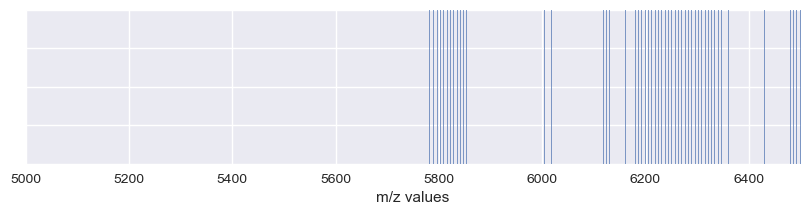

In [88]:
#Plot segmentation of m/z range
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(10,2))
plt.eventplot(change_values, linewidths=0.5)
plt.xlabel('m/z values')
plt.tick_params(left = False, labelleft=False)
plt.xlim(5000,6500)
plt.ylim(0.9,1.1)

(0.9, 1.1)

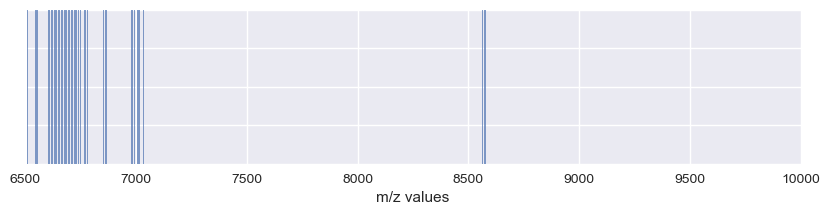

In [94]:
#Plot segmentation of m/z range
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(10,2))
plt.eventplot(change_values, linewidths=0.5)
plt.xlabel('m/z values')
plt.tick_params(left = False, labelleft=False)
plt.xlim(6500,10000)
plt.ylim(0.9,1.1)

(0.9, 1.1)

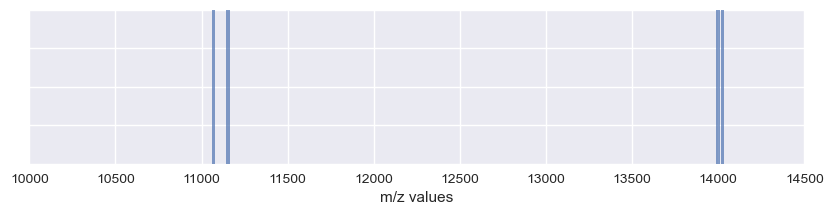

In [95]:
#Plot segmentation of m/z range
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(10,2))
plt.eventplot(change_values, linewidths=0.5)
plt.xlabel('m/z values')
plt.tick_params(left = False, labelleft=False)
plt.xlim(10000,14500)
plt.ylim(0.9,1.1)